## NY Taxi - duration prediction

In [88]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

from sklearn.metrics import mean_squared_error

import pickle

In [2]:
pd.__version__

'2.2.3'

## Read file from web directly

In [3]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet")

In [4]:
df.shape

(46621, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46621 entries, 0 to 46620
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               46621 non-null  int32         
 1   lpep_pickup_datetime   46621 non-null  datetime64[us]
 2   lpep_dropoff_datetime  46621 non-null  datetime64[us]
 3   store_and_fwd_flag     44104 non-null  object        
 4   RatecodeID             44104 non-null  float64       
 5   PULocationID           46621 non-null  int32         
 6   DOLocationID           46621 non-null  int32         
 7   passenger_count        44104 non-null  float64       
 8   trip_distance          46621 non-null  float64       
 9   fare_amount            46621 non-null  float64       
 10  extra                  46621 non-null  float64       
 11  mta_tax                46621 non-null  float64       
 12  tip_amount             46621 non-null  float64       
 13  t

In [6]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-02-01 00:12:15,2025-02-01 00:15:48,N,1.0,166,41,1.0,0.65,6.5,...,0.5,1.80,0.0,NaN,1.0,10.80,1.0,1.0,0.00,0.00
1,2,2025-01-31 23:57:05,2025-02-01 00:24:24,N,1.0,255,161,1.0,6.57,31.7,...,0.5,0.00,0.0,NaN,1.0,37.70,2.0,1.0,2.75,0.75
2,2,2025-02-01 00:24:26,2025-02-01 00:49:54,N,1.0,75,182,2.0,8.36,36.6,...,0.5,0.00,0.0,NaN,1.0,39.10,2.0,1.0,0.00,0.00
3,1,2025-02-01 00:17:15,2025-02-01 00:25:56,N,1.0,97,209,1.0,2.40,12.8,...,1.5,3.75,0.0,NaN,1.0,22.55,1.0,1.0,2.75,0.75
4,2,2025-02-01 00:17:36,2025-02-01 00:26:36,N,1.0,7,223,1.0,1.31,10.7,...,0.5,2.64,0.0,NaN,1.0,15.84,1.0,1.0,0.00,0.00


In [7]:
# Filter by trip_type
df = df[df.trip_type == 2]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
8,2,2025-02-01 00:24:21,2025-02-01 00:24:22,N,5.0,264,264,0.0,0.00,14.0,...,0.0,1.0,0.0,NaN,1.0,16.0,1.0,2.0,0.00,0.00
19,2,2025-02-01 00:22:16,2025-02-01 00:49:50,N,5.0,181,48,2.0,7.02,50.0,...,0.0,5.0,0.0,NaN,1.0,59.5,1.0,2.0,2.75,0.75
20,2,2025-02-01 01:02:17,2025-02-01 01:04:42,N,5.0,40,40,1.0,0.00,7.0,...,0.0,0.0,0.0,NaN,1.0,8.0,1.0,2.0,0.00,0.00
21,2,2025-02-01 00:19:32,2025-02-01 00:43:22,N,5.0,255,263,2.0,5.66,55.0,...,0.0,11.9,0.0,NaN,1.0,71.4,1.0,2.0,2.75,0.75
27,2,2025-02-01 00:48:21,2025-02-01 01:11:45,N,5.0,255,90,2.0,4.84,60.0,...,0.0,12.9,0.0,NaN,1.0,77.4,1.0,2.0,2.75,0.75


In [8]:
# Needed only in case pandas does not parse datetime correctly
# df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
# df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

# OR

df.loc[:, 'lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
df.loc[:, 'lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])

In [9]:
# Finding trip duration
df.lpep_dropoff_datetime - df.lpep_pickup_datetime

8       0 days 00:00:01
19      0 days 00:27:34
20      0 days 00:02:25
21      0 days 00:23:50
27      0 days 00:23:24
              ...      
44051   0 days 00:00:03
44065   0 days 00:00:14
44067   0 days 00:22:32
44070   0 days 00:19:20
44100   0 days 00:12:58
Length: 1683, dtype: timedelta64[us]

In [10]:
# Create duration column
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
8,2,2025-02-01 00:24:21,2025-02-01 00:24:22,N,5.0,264,264,0.0,0.00,14.0,...,1.0,0.0,NaN,1.0,16.0,1.0,2.0,0.00,0.00,0 days 00:00:01
19,2,2025-02-01 00:22:16,2025-02-01 00:49:50,N,5.0,181,48,2.0,7.02,50.0,...,5.0,0.0,NaN,1.0,59.5,1.0,2.0,2.75,0.75,0 days 00:27:34
20,2,2025-02-01 01:02:17,2025-02-01 01:04:42,N,5.0,40,40,1.0,0.00,7.0,...,0.0,0.0,NaN,1.0,8.0,1.0,2.0,0.00,0.00,0 days 00:02:25
21,2,2025-02-01 00:19:32,2025-02-01 00:43:22,N,5.0,255,263,2.0,5.66,55.0,...,11.9,0.0,NaN,1.0,71.4,1.0,2.0,2.75,0.75,0 days 00:23:50
27,2,2025-02-01 00:48:21,2025-02-01 01:11:45,N,5.0,255,90,2.0,4.84,60.0,...,12.9,0.0,NaN,1.0,77.4,1.0,2.0,2.75,0.75,0 days 00:23:24


### Convert duration to min

In [11]:
td = df.duration.iloc[150]

In [12]:
td

Timedelta('0 days 00:15:14')

In [13]:
td.total_seconds()

914.0

In [14]:
td.total_seconds() / 60

15.233333333333333

In [15]:
# Convert duration coulmn in df to minutes
df.duration = df.duration.apply(lambda td:td.total_seconds() / 60)

In [16]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
8,2,2025-02-01 00:24:21,2025-02-01 00:24:22,N,5.0,264,264,0.0,0.00,14.0,...,1.0,0.0,NaN,1.0,16.0,1.0,2.0,0.00,0.00,0.016667
19,2,2025-02-01 00:22:16,2025-02-01 00:49:50,N,5.0,181,48,2.0,7.02,50.0,...,5.0,0.0,NaN,1.0,59.5,1.0,2.0,2.75,0.75,27.566667
20,2,2025-02-01 01:02:17,2025-02-01 01:04:42,N,5.0,40,40,1.0,0.00,7.0,...,0.0,0.0,NaN,1.0,8.0,1.0,2.0,0.00,0.00,2.416667
21,2,2025-02-01 00:19:32,2025-02-01 00:43:22,N,5.0,255,263,2.0,5.66,55.0,...,11.9,0.0,NaN,1.0,71.4,1.0,2.0,2.75,0.75,23.833333
27,2,2025-02-01 00:48:21,2025-02-01 01:11:45,N,5.0,255,90,2.0,4.84,60.0,...,12.9,0.0,NaN,1.0,77.4,1.0,2.0,2.75,0.75,23.400000


In [17]:
df.shape

(1683, 22)

/tmp/ipykernel_3778/533639664.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

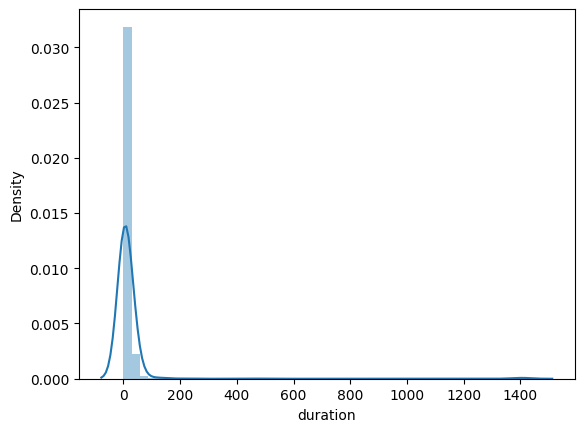

In [18]:
# Visualize distribution of duration
sns.distplot(df.duration)

In [19]:
df.duration.describe()

count    1683.000000
mean       19.211398
std       114.733352
min         0.000000
25%         0.083333
50%         1.833333
75%        14.216667
max      1434.583333
Name: duration, dtype: float64

In [20]:
# look at percentile
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    1683.000000
mean       19.211398
std       114.733352
min         0.000000
50%         1.833333
95%        38.346667
98%        60.922667
99%       146.624333
max      1434.583333
Name: duration, dtype: float64

### Most trips are around or less than 1 hour

In [21]:
# Filter for 1 min to 60 min duration
(df.duration >= 1) & (df.duration <= 60)

8        False
19        True
20        True
21        True
27        True
         ...  
44051    False
44065    False
44067     True
44070     True
44100     True
Name: duration, Length: 1683, dtype: bool

In [22]:
((df.duration >= 1) & (df.duration <= 60)).mean()

np.float64(0.5210932857991681)

In [23]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
19,2,2025-02-01 00:22:16,2025-02-01 00:49:50,N,5.0,181,48,2.0,7.02,50.0,...,5.00,0.0,NaN,1.0,59.5,1.0,2.0,2.75,0.75,27.566667
20,2,2025-02-01 01:02:17,2025-02-01 01:04:42,N,5.0,40,40,1.0,0.00,7.0,...,0.00,0.0,NaN,1.0,8.0,1.0,2.0,0.00,0.00,2.416667
21,2,2025-02-01 00:19:32,2025-02-01 00:43:22,N,5.0,255,263,2.0,5.66,55.0,...,11.90,0.0,NaN,1.0,71.4,1.0,2.0,2.75,0.75,23.833333
27,2,2025-02-01 00:48:21,2025-02-01 01:11:45,N,5.0,255,90,2.0,4.84,60.0,...,12.90,0.0,NaN,1.0,77.4,1.0,2.0,2.75,0.75,23.400000
55,1,2025-02-01 02:46:39,2025-02-01 03:02:29,N,5.0,80,79,2.0,5.20,55.0,...,11.15,0.0,NaN,0.0,66.9,1.0,2.0,0.00,0.75,15.833333


In [24]:
df.shape

(877, 22)

In [25]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
19,2,2025-02-01 00:22:16,2025-02-01 00:49:50,N,5.0,181,48,2.0,7.02,50.0,...,5.00,0.0,NaN,1.0,59.50,1.0,2.0,2.75,0.75,27.566667
20,2,2025-02-01 01:02:17,2025-02-01 01:04:42,N,5.0,40,40,1.0,0.00,7.0,...,0.00,0.0,NaN,1.0,8.00,1.0,2.0,0.00,0.00,2.416667
21,2,2025-02-01 00:19:32,2025-02-01 00:43:22,N,5.0,255,263,2.0,5.66,55.0,...,11.90,0.0,NaN,1.0,71.40,1.0,2.0,2.75,0.75,23.833333
27,2,2025-02-01 00:48:21,2025-02-01 01:11:45,N,5.0,255,90,2.0,4.84,60.0,...,12.90,0.0,NaN,1.0,77.40,1.0,2.0,2.75,0.75,23.400000
55,1,2025-02-01 02:46:39,2025-02-01 03:02:29,N,5.0,80,79,2.0,5.20,55.0,...,11.15,0.0,NaN,0.0,66.90,1.0,2.0,0.00,0.75,15.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44002,2,2025-02-28 22:09:36,2025-02-28 22:37:30,N,5.0,181,164,1.0,8.10,75.0,...,15.90,0.0,NaN,1.0,95.40,1.0,2.0,2.75,0.75,27.900000
44017,2,2025-02-28 22:56:37,2025-02-28 23:07:57,N,5.0,66,209,1.0,2.16,34.0,...,7.70,0.0,NaN,1.0,46.20,1.0,2.0,2.75,0.75,11.333333
44067,2,2025-02-28 23:02:02,2025-02-28 23:24:34,N,5.0,66,48,2.0,6.06,43.0,...,9.50,0.0,NaN,1.0,57.00,1.0,2.0,2.75,0.75,22.533333
44070,2,2025-02-28 23:17:52,2025-02-28 23:37:12,N,5.0,33,150,1.0,13.66,70.0,...,5.25,0.0,NaN,1.0,76.25,1.0,2.0,0.00,0.00,19.333333


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 877 entries, 19 to 44100
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               877 non-null    int32         
 1   lpep_pickup_datetime   877 non-null    datetime64[us]
 2   lpep_dropoff_datetime  877 non-null    datetime64[us]
 3   store_and_fwd_flag     877 non-null    object        
 4   RatecodeID             877 non-null    float64       
 5   PULocationID           877 non-null    int32         
 6   DOLocationID           877 non-null    int32         
 7   passenger_count        877 non-null    float64       
 8   trip_distance          877 non-null    float64       
 9   fare_amount            877 non-null    float64       
 10  extra                  877 non-null    float64       
 11  mta_tax                877 non-null    float64       
 12  tip_amount             877 non-null    float64       
 13  tolls_a

## Feature selection

In [27]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [28]:
df[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

- In order to use 1-hot encoding using dictvectorizer, we need to make categorical features dtypes - str

In [29]:
df[categorical] = df[categorical].astype(str)

In [31]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [33]:
# First few rows as dict
df[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '181', 'DOLocationID': '48', 'trip_distance': 7.02},
 {'PULocationID': '40', 'DOLocationID': '40', 'trip_distance': 0.0},
 {'PULocationID': '255', 'DOLocationID': '263', 'trip_distance': 5.66},
 {'PULocationID': '255', 'DOLocationID': '90', 'trip_distance': 4.84},
 {'PULocationID': '80', 'DOLocationID': '79', 'trip_distance': 5.2},
 {'PULocationID': '80', 'DOLocationID': '257', 'trip_distance': 9.4},
 {'PULocationID': '255', 'DOLocationID': '68', 'trip_distance': 5.19},
 {'PULocationID': '80', 'DOLocationID': '230', 'trip_distance': 7.28},
 {'PULocationID': '157', 'DOLocationID': '107', 'trip_distance': 5.24},
 {'PULocationID': '157', 'DOLocationID': '255', 'trip_distance': 2.23}]

In [34]:
# Create train dict
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [36]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [37]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2631 stored elements and shape (877, 263)>

In [38]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=102',
 'DOLocationID=107',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=116',
 'DOLocationID=119',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=148',
 'DOLocationID=149',
 'DOLocationID=150',
 'DOLocationID=151',
 'DOLocationID=152',
 'DOLocationID=157',
 'DOLocationID=159',
 'DOLocationID=160',
 'DOLocationID=161',
 'DOLocationID=163',
 'DOLocationID=164',
 'DOLocationID=166',
 'DOLocationID=167',
 'DOLocationID=168',
 'DOLocationID=169

In [41]:
target = "duration"
y_train = df[target].values

In [44]:
y_train[:5]

array([27.56666667,  2.41666667, 23.83333333, 23.4       , 15.83333333])

## Train model

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### Predict on same dataset for now

In [47]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_3778/1545470367.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = "prediction")
/tmp/ipykernel_3778/1545470367.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = "actual")


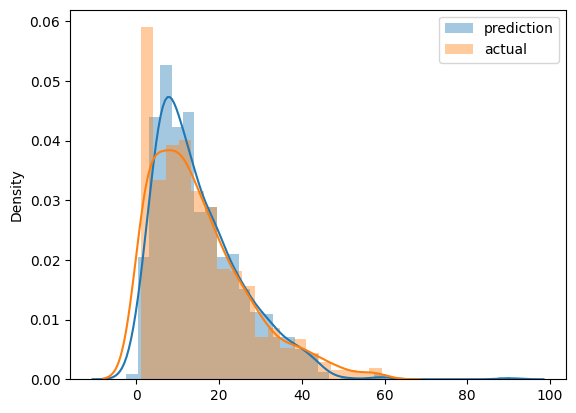

In [50]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train, label = "actual")

plt.legend()

In [53]:
mean_squared_error(y_train, y_pred)

26.543290133432137

In [62]:
np.sqrt(mean_squared_error(y_train, y_pred))

np.float64(5.1520180641601145)

- This means, our model predicts within +- 5.15 min of actual trip durations

## Let's try improving the model

1. Move data pre-processing to a function
2. train, test split
3. Use Lasso regression
4. Experiment with additional features

In [66]:
# pre-processing function

def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.loc[:, 'lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])
    df.loc[:, 'lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td:td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    # numerical = ["trip_distance"]
    
    df[categorical] = df[categorical].astype(str)

    return df

In [67]:
# Let's use Jan data for validation
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet")

In [68]:
len(df_train), len(df_val)

(44218, 46307)

In [69]:
# Trainging pipeline

categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [ ]:
target = "duration"
y_train = df[target].values

In [70]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [71]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred =lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(6.954220877892599)

- error is slightly worse now

## Let's try Lasso 

In [74]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred =lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(6.878168964636033)

## Let's try Ridge

In [81]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred =lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(6.936694826405385)

## Let's add more features

In [82]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [83]:
# Trainging pipeline

categorical = ['PU_DO'] #["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [84]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [85]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred =lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(5.747151799903688)

In [89]:
lr = Lasso(alpha=0.0001)
lr.fit(X_train, y_train)

y_pred =lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(5.737832328868111)

In [87]:
lr = Ridge()
lr.fit(X_train, y_train)

y_pred =lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(5.673656590604417)

## Save model

In [90]:
# Train final model
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred =lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(5.747151799903688)

In [93]:
# Save model
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)